In [1]:
import sys
import os
sys.path.append('..')

In [2]:
from workspace import nometools as nome

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.stats import pearsonr

In [4]:
main_path = '/home/kevin/DNA-Methylation-patterns/'
data_path = main_path + 'ctcf/'
steric_path = main_path + 'ctcf/steric_clash/'

In [5]:
np.random.seed(1234)

#### Promoter annotation and sorting

In [6]:
def get_ctcf_regions(infile, outfile):
    seen_coords = set()
    itr = 0
    prev_end_pos = 0
    prev_end_neg = 0
    with open(outfile, 'w') as fout:
        with open(infile, 'r') as fin:
            for line in fin:
                if not line.startswith('#'):
                    line_s = line.strip().split('\t')

                    refid = line_s[0]
                    chrom = line_s[0]
                    strand = line_s[4]
                    ctcfStart = int(line_s[1])
                    ctcfEnd = int(line_s[2])
                    geneName = line_s[0]

                    coords = chrom + str(ctcfStart) + str(ctcfEnd) + strand
                    if coords not in seen_coords:
                        seen_coords.add(coords)

                        promo_start = 2000
                        promo_end = 1000

                        if strand == "+":
                            promoter_start = ctcfStart - promo_start
                            promoter_end = ctcfStart + promo_end
                        else:
                            promoter_start = ctcfEnd - promo_end
                            promoter_end = ctcfEnd + promo_start
                        
                        if promoter_start < 0:
                            promoter_start = 0
                            continue

                        # if strand == '+':
                        #     if promoter_start < prev_end_pos:
                        #         continue
                        #     else:
                        #         prev_end_pos = promoter_end
                        # else:
                        #     if promoter_start < prev_end_neg:
                        #         continue
                        #     else:
                        #         prev_end_neg = promoter_end

                        if '_' not in chrom:
                            fout.write('\t'.join([str(s) for s in [chrom, promoter_start, promoter_end, refid, geneName, ctcfStart, ctcfEnd, strand]]) + '\n')
                            itr += 1

    print('no of ctcf defined :', itr)
    print('ctcf regions saved to {}'.format(outfile))

In [ ]:
# # Getting introns from refGene

# infile = data_path + 'CTCF_hg19.bed'
# outfile = data_path + 'ctcf.bed'
# get_ctcf_regions(infile, outfile)                    

In [7]:
outfile = data_path + 'ctcf.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 871135


In [8]:
# sorting bed files introns

infile = data_path + 'ctcf.bed'
outfile = data_path + 'ctcf.sorted.bed'

nome.sort_bed(infile, outfile)

In [ ]:
## checking length of intron regions

infile = data_path + 'ctcf.sorted.bed'
temp = []
with open(infile, 'r') as fin:
    for line in fin:
        line_s = line.strip().split('\t')
        chrom = line_s[0]
        strand = line_s[-1]
        i_start = int(line_s[1])
        i_end = int(line_s[2])
        c_start = int(line_s[5])
        c_end = int(line_s[6])

        temp.append([chrom, i_start, i_end, strand, c_start, c_end])

df_introns = pd.DataFrame(temp, columns=['chr', 'start', 'end', 'strand', 'c_start', 'c_end'])

In [ ]:
df_introns.head()

In [ ]:
reg_len = df_introns['c_end'] - df_introns['c_start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len)
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

In [ ]:
reg_len = df_introns['end'] - df_introns['start'] 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(reg_len[np.all(pd.concat([reg_len > 900, reg_len < 10000], axis=1), axis=1)])
plt.xlabel('intron length')
plt.subplot(1,2,2)
plt.hist(np.log10(reg_len))
plt.xlabel('log(intron length)')
plt.show()

In [ ]:
### Removing overlapping regions

In [9]:
infile = data_path + 'ctcf.sorted.bed'
df = pd.read_csv(infile, sep='\t', names=['chr', 'start', 'end', '1', '2', 'start_', 'end_', 'strand'])

In [10]:
df.head()

,chr,start,end,1,2,start_,end_,strand
0,chr1,9414,12414,chr1,chr1,11414,11432,+
1,chr1,9489,12489,chr1,chr1,10471,10489,-
2,chr1,10182,13182,chr1,chr1,11164,11182,-
3,chr1,10241,13241,chr1,chr1,11223,11241,-
4,chr1,10299,13299,chr1,chr1,11281,11299,-


In [11]:
# Function to check overlap between two intervals
def has_overlap(row, other):
    return row['end'] > other['start']

# Function to filter rows with overlapping intervals
def filter_overlapping(df):
    to_keep = []
    i = 0
    while i < df.shape[0]:
        if i%7000 == 0:
            print(f'done : {round(i*100/df.shape[0],2)}')
        no_overlap = False
        row = df.iloc[i]
        for j in range(i+1, df.shape[0]):
            other = df.iloc[j]
            if not has_overlap(row, other):
                no_overlap = True
                break

        if no_overlap:
            to_keep.append(i)
            i = j
        else:
            to_keep.append(i)
            i = j+1

    return df.iloc[to_keep]

# Apply the function within each chromosome group
filtered_df = df.groupby('chr').apply(filter_overlapping).reset_index(drop=True)

done : 0.0
done : 37.8
done : 0.0
done : 16.37
done : 49.12
done : 81.87
done : 98.24
done : 0.0
done : 48.8
done : 65.07
done : 0.0
done : 36.74
done : 55.11
done : 91.85
done : 0.0
done : 31.54
done : 0.0
done : 25.6
done : 0.0
done : 48.9
done : 0.0
done : 20.52
done : 41.05
done : 61.57
done : 0.0
done : 0.0
done : 35.19
done : 0.0
done : 45.69
done : 91.38
done : 0.0
done : 72.45
done : 82.8
done : 93.15
done : 0.0
done : 0.0
done : 0.0
done : 34.93
done : 69.86
done : 0.0
done : 13.71
done : 41.14
done : 68.57
done : 0.0
done : 33.5
done : 83.75
done : 0.0
done : 15.57
done : 62.29
done : 0.0
done : 16.11
done : 32.21
done : 48.32
done : 80.53
done : 96.64
done : 0.0
done : 29.77
done : 44.66
done : 74.43
done : 0.0
done : 51.93
done : 0.0
done : 0.0
done : 19.25
done : 57.75
done : 76.99
done : 0.0


In [14]:
filtered_df.head()

,chr,start,end,1,2,start_,end_,strand
0,chr1,9414,12414,chr1,chr1,11414,11432,+
1,chr1,13249,16249,chr1,chr1,14231,14249,-
2,chr1,17376,20376,chr1,chr1,18358,18376,-
3,chr1,20562,23562,chr1,chr1,22562,22580,+
4,chr1,23800,26800,chr1,chr1,24782,24800,-


In [13]:
filtered_df.shape, df.shape

((395767, 8), (871135, 8))

In [15]:
outfile = data_path + 'ctcf.filtered.bed'
filtered_df.to_csv(outfile, sep='\t', header=False, index=False)

In [16]:
outfile = data_path + 'ctcf.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 871135


In [17]:
outfile = data_path + 'ctcf.filtered.bed'
print('no of introns :', nome.get_num_reads(outfile))

no of introns : 395767


In [18]:
# sorting bed files introns

infile = data_path + 'ctcf.filtered.bed'
outfile = data_path + 'ctcf.filtered.sorted.bed'

nome.sort_bed(infile, outfile)

#### GCH filtering and intersection

In [19]:
## nucleotide added here
def filter_bed_files(infile, outfile, min_cov=3):
    chroms_seen = set()
    non_std_chroms = set()
    chroms = ['chr' + str(i) for i in range(1,23)] + ['chrX', 'chrY']

    n = 0
    with open(infile, 'r') as fin:
        n = sum(1 for _ in fin)

    progress_check = int(n/10)
    itr = 0
    with open(outfile, 'w') as fout:
        with open(infile, 'r') as fin:
            print('start traversing bed file ', infile, 'n = ', n)
            curr_time = time.time()
            for line in fin:
                if itr != 0 and itr%progress_check == 0:
                    print('progress : {}% and time elapsed {} min'.format(round(itr*100/n,2), round((time.time()-curr_time)/60,2)))

                itr += 1
                if not line.startswith('track'):
                    line_s = line.strip().split('\t')

                    assert len(line_s) == 11
                    
                    chrom = 'chr' + line_s[0]
                    if chrom in chroms:
                        chroms_seen.add(chrom)

                        start = int(line_s[1])
                        end = int(line_s[2])
                        methyl_rate = float(line_s[3])
                        coverage = int(line_s[4])
                        strand = line_s[5]
                        nt = "G" if strand == "-" else "C"

                        if coverage >= min_cov:
                            fout.write('\t'.join([str(x) for x in [chrom, start, end, strand, methyl_rate, coverage, nt]]) + '\n')
                    else:
                        if chrom not in non_std_chroms:
                            non_std_chroms.add(chrom)

    assert len(chroms_seen) == 24

    print('filered bed file with min coverage {} and saved to {}'.format(min_cov, outfile))
    print('Non standard chrs seen : ', non_std_chroms)

In [20]:
# # Filtering GCH file
# # Filtering for reads with coverage >= 3

# infile = data_path + 'cpg.raw.sort.GCH.bed'
# outfile = data_path + 'GCH.filtered.bed'

# filter_bed_files(infile, outfile)

In [21]:
# infile = data_path + 'cpg.raw.sort.HCG.bed'
# outfile = data_path + 'HCG.filtered.bed'

# filter_bed_files(infile, outfile)

In [22]:
import subprocess
def sort_bed(infile):
    '''
        sort -k1,1V -k2,2n /loc/GCH.filtered.bed > /loc/sorted.bed
    '''
    res = subprocess.run(['sort', '-k1,1V', '-k2,2n', f'{infile}'], capture_output=True, text=True)

    outfile = infile.replace('.bed', '.sorted.bed')
    if res.returncode == 0:
        with open(outfile, 'w') as fout:
            fout.write(res.stdout)
    else:
        print('error in sorting')

In [23]:
# sort_bed(data_path + 'GCH.filtered.bed')
# sort_bed(data_path + 'HCG.filtered.bed')

In [24]:
def intersect_bed(file1, file2, outfile):
    '''
        bedtools intersect -a fa -b fb -wa -wb -sorted
    '''
    res = subprocess.run(['bedtools', 'intersect', '-a', f'{file1}', '-b', f'{file2}', '-wa', '-wb', '-sorted'],
                          capture_output=True, text=True)

    if res.returncode == 0:
        with open(outfile, 'w') as fout:
            fout.write(res.stdout)
    else:
        print('error in intersect')

In [25]:
# GCH intersect with introns

introns_sorted = data_path + 'ctcf.filtered.sorted.bed'
gch_sorted = data_path + 'GCH.filtered.sorted.bed'
outfile = data_path + 'GCH.regions.intersect.bed'

intersect_bed(introns_sorted, gch_sorted, outfile)

In [26]:
promoters_sorted = data_path + 'ctcf.filtered.sorted.bed'
gch_sorted = data_path + 'HCG.filtered.sorted.bed'
outfile = data_path + 'HCG.regions.intersect.bed'

intersect_bed(promoters_sorted, gch_sorted, outfile)

In [27]:
# sizes are different from directly loading the intersect.bed using pandas
# we are loosing some values
def get_methylation(infile, region='region'):
    inter_dict = dict()
    seen_ids = set()

    with open(infile) as f:
        for line in tqdm(f):
            line_s = line.strip().split('\t')

            chrom = line_s[0]            
            region_start = int(line_s[1])
            region_end = int(line_s[2])
            refid = line_s[3]
            gene_name = line_s[4]
            TSS = int(line_s[5])
            TES = int(line_s[6])
            strand = line_s[7]
            meth_start = int(line_s[9])
            meth_end = int(line_s[10])
            meth_rate = float(line_s[12])
            coverage = int(line_s[13])
            nt = line_s[14]

            dict_id = refid + "-" + str(region_start)
            
            ## We are checking + and -ve strands based on promoter
            if strand == "+":
                intron_abs_pos = meth_start - region_start
            if strand == "-":
                intron_abs_pos = region_end - meth_end
        
            rel_pos = intron_abs_pos - 2000
        
            if dict_id not in seen_ids:
                seen_ids.add(dict_id)
                inter_dict[dict_id] = dict()
            
            inter_dict[dict_id][meth_start] = dict()
            
            inter_dict[dict_id][meth_start]["chrom"] = chrom
            inter_dict[dict_id][meth_start][f"{region}_start"] = region_start
            inter_dict[dict_id][meth_start][f"{region}_end"] = region_end
            inter_dict[dict_id][meth_start]["gene_name"] = gene_name
            inter_dict[dict_id][meth_start]["TSS"] = TSS
            inter_dict[dict_id][meth_start]["TES"] = TES
            inter_dict[dict_id][meth_start]["strand"] = strand
            
            inter_dict[dict_id][meth_start]["meth_start_genome"] = meth_start
            inter_dict[dict_id][meth_start]["meth_end_genome"] = meth_end
            inter_dict[dict_id][meth_start]["meth_pos_abs"] = intron_abs_pos
            inter_dict[dict_id][meth_start]["meth_pos_rel"] = rel_pos
                        
            inter_dict[dict_id][meth_start]["meth_rate"] = meth_rate
            inter_dict[dict_id][meth_start]["coverage"] = coverage
            inter_dict[dict_id][meth_start]["nt"] = nt

    column_names = ['trans_id', 'refid', 'gene_name', 'chrom', f'{region}_start', f'{region}_end', 
                    'TSS', 'TES', 'strand', 'meth_start_genome', 'meth_end_genome', 'meth_pos_abs',
                    'meth_pos_rel', 'meth_rate', 'coverage', 'nt']

    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    ## Can create a filter for no of GCH or HCG in a promoter
    for dict_id in inter_dict.keys():
        refid = dict_id.split("-")[0]
        for promo_start in inter_dict[dict_id].keys():
            info_dict["trans_id"].append(dict_id)
            info_dict["refid"].append(refid)
            info_dict["gene_name"].append(inter_dict[dict_id][promo_start]["gene_name"])
            info_dict["chrom"].append(inter_dict[dict_id][promo_start]["chrom"])
            info_dict[f"{region}_start"].append(inter_dict[dict_id][promo_start][f"{region}_start"])
            info_dict[f"{region}_end"].append(inter_dict[dict_id][promo_start][f"{region}_end"])
            info_dict["TSS"].append(inter_dict[dict_id][promo_start]["TSS"])
            info_dict["TES"].append(inter_dict[dict_id][promo_start]["TES"])
            info_dict["strand"].append(inter_dict[dict_id][promo_start]["strand"])
            
            info_dict["meth_start_genome"].append(inter_dict[dict_id][promo_start]["meth_start_genome"])
            info_dict["meth_end_genome"].append(inter_dict[dict_id][promo_start]["meth_end_genome"])
            info_dict["meth_pos_abs"].append(inter_dict[dict_id][promo_start]["meth_pos_abs"])
            info_dict["meth_pos_rel"].append(inter_dict[dict_id][promo_start]["meth_pos_rel"])
            
            info_dict["meth_rate"].append(inter_dict[dict_id][promo_start]["meth_rate"])
            info_dict["coverage"].append(inter_dict[dict_id][promo_start]["coverage"])
            info_dict["nt"].append(inter_dict[dict_id][promo_start]["nt"])

    # Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["refid"])), columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]  
        
    df = df.sort_values(by = ['chrom', f'{region}_start'], ascending = [True, True])

    return df

In [28]:
infile = data_path + 'GCH.regions.intersect.bed'
df_GCH_intersect = get_methylation(infile)

44263493it [03:29, 211018.34it/s]


In [29]:
df_GCH_intersect.shape

(44126754, 16)

In [30]:
df_GCH_intersect.head()

,trans_id,refid,gene_name,chrom,region_start,region_end,TSS,TES,strand,meth_start_genome,meth_end_genome,meth_pos_abs,meth_pos_rel,meth_rate,coverage,nt
0,chr1-13249,chr1,chr1,chr1,13249,16249,14231,14249,-,15184,15185,1064,-936,0.0,5,G
1,chr1-13249,chr1,chr1,chr1,13249,16249,14231,14249,-,15191,15192,1057,-943,20.0,5,G
2,chr1-13249,chr1,chr1,chr1,13249,16249,14231,14249,-,15205,15206,1043,-957,0.0,5,G
3,chr1-13249,chr1,chr1,chr1,13249,16249,14231,14249,-,15208,15209,1040,-960,0.0,5,G
4,chr1-13249,chr1,chr1,chr1,13249,16249,14231,14249,-,15220,15221,1028,-972,0.0,5,G


In [31]:
infile = data_path + 'HCG.regions.intersect.bed'
df_HCG_intersect = get_methylation(infile)

6957415it [00:29, 233924.74it/s]


In [32]:
df_HCG_intersect.shape

(6936556, 16)

In [33]:
def plot_avg_methylation_levels(df, context, select_genes=[], fig = True, c = 'grey', label = None, rel=False, inter_start=None, inter_end=None):
    
    if len(select_genes) == 0: 
        all_meth_pos_rel = list(df['meth_pos_rel'])
        all_meth_rate = list(df['meth_rate'])
        all_coverage = list(df['coverage'])

        assert len(all_meth_pos_rel) == len(all_meth_rate) == len(all_coverage)

        av_dict = dict()
        seen_pos = set()
        for p in range(len(all_meth_pos_rel)):
            rel_pos_x = all_meth_pos_rel[p]
            meth_rate = all_meth_rate[p]
            coverage = all_coverage[p]
            
            #AVERAGE
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []
            
            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
    else:
        av_dict = {}
        seen_pos = set()
        group = df[df['gene_name'].isin(select_genes)]
        for rel_pos_x, meth_rate, coverage in zip(group['meth_pos_rel'], group['meth_rate'], group['coverage']):
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []

            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
            

    if fig:
        plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

    x = []
    y = []

    for rel_pos_x in sorted(av_dict.keys()):
        if rel:
            if rel_pos_x >= inter_start and rel_pos_x <= inter_end:
                if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
                    x.append(rel_pos_x)
                    y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))
        else:
            if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
                x.append(rel_pos_x)
                y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

    if label is None:
        plt.plot(x, y, "-", color=c, alpha=1.0)
    else:
        plt.plot(x, y, "-", color=c, label=label, alpha=0.7)
        plt.legend()
        
    plt.xlabel("DNA position [bp]")
    plt.xlim(-2000,1000)

    if context == 'GCH':
        ylab = "100-GpC methylation level"
    if context == 'HCG':
        ylab = "CpG methylation level"
    plt.ylabel(ylab)

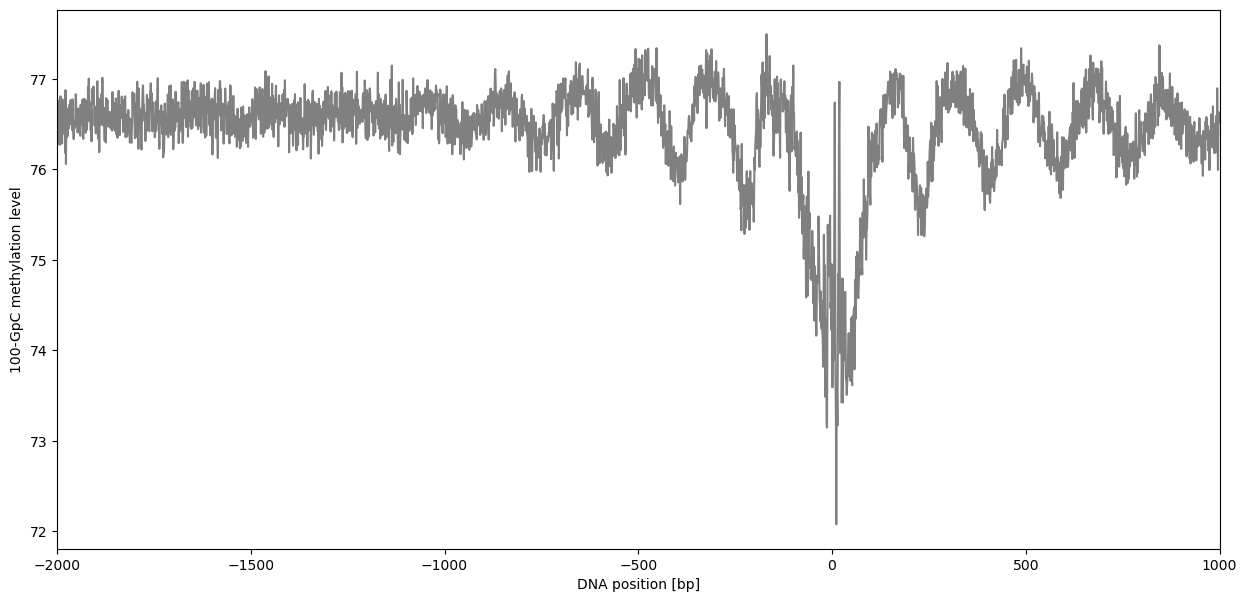

In [34]:
plot_avg_methylation_levels(df_GCH_intersect, 'GCH')

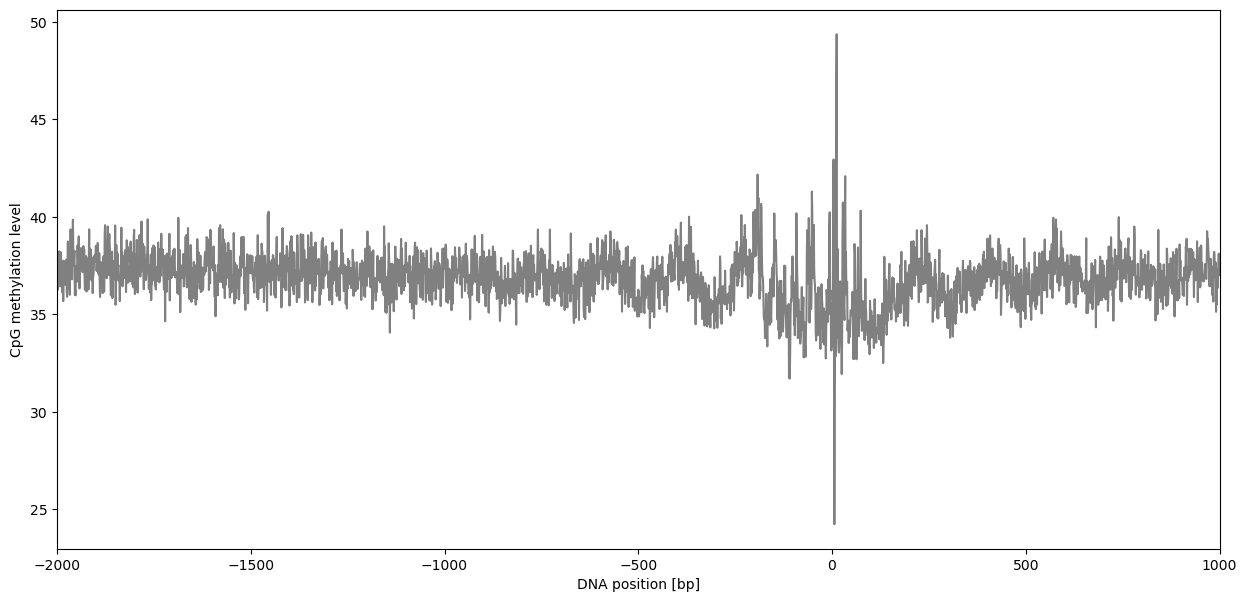

In [35]:
plot_avg_methylation_levels(df_HCG_intersect, 'HCG')

In [36]:
infile = data_path + 'HCG.regions.intersect.bed'
cols = ['chrom', 'region_start', 'region_end', 'refid', 'gene_name', 
        'TSS', 'TES', 'strand', 'chrom_', 'meth_start_genome', 'meth_end_genome', 
        'strand_', 'meth_rate', 'coverage', 'nt']
df_HCG_intersect_random = pd.read_csv(infile, sep='\t', names=cols)
df_HCG_intersect_random['meth_rate'] = df_HCG_intersect_random['meth_rate'].sample(frac=1).reset_index(drop=True)
outfile = data_path + 'HCG.regions.intersect.random.bed'
df_HCG_intersect_random.to_csv(outfile, sep='\t', header=False, index=False)

In [37]:
infile = data_path + 'HCG.regions.intersect.random.bed'
df_HCG_intersect_random = get_methylation(infile)

6957415it [00:34, 198830.77it/s]


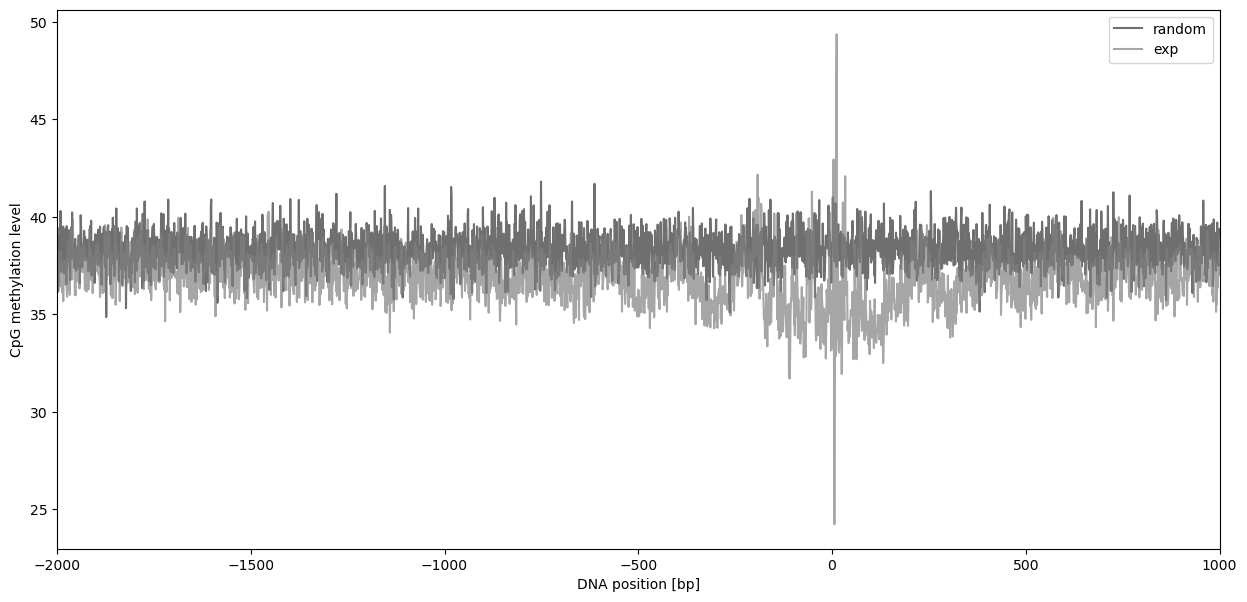

In [38]:
plot_avg_methylation_levels(df_HCG_intersect_random, 'HCG', fig=True, c='#333232', label='random')
plot_avg_methylation_levels(df_HCG_intersect, 'HCG', fig=False, label='exp')

In [39]:
df_HCG_intersect_random.shape, df_HCG_intersect.shape

((6936556, 16), (6936556, 16))

In [40]:
def plot_CpG_CpG_dist(df, max_dist=20, c='grey'):
    dist_list = []
    chroms = ['chr' + str(i) for i in range(1,23)] + ['chrX', 'chrY']
    for chrom in chroms:
        #### ALL methylated pos
        all_meth_pos = list(df.loc[(df["meth_rate"] != 0) & 
                                   (df["chrom"] == chrom) & 
                                   (df["nt"] == "C")]["meth_start_genome"])
        all_meth_pos_sorted = sorted(list(set(all_meth_pos))) # since mapped to promoter, CpG can be twice if promoter overlap, make set

        for pos in range(len(all_meth_pos_sorted) - 1):
            start = all_meth_pos_sorted[pos]
            next_start = all_meth_pos_sorted[pos+1]
            dist = next_start - start - 1 # is number of bases inbetween
            
            if dist <= max_dist:
                dist_list.append(dist)

    y = []
    for r in range(max_dist+1):
        freq = float(dist_list.count(r))/float(len(dist_list))*100
        y.append(freq)


    plt.figure(facecolor='w', edgecolor='k')

    x = np.arange(len(y))
    plt.bar(x, y, align='center', color=c)

    plt.xlabel("Distance to next 5meC [bp]")
    plt.ylabel("Percentage [%]")
    plt.xlim(1, max_dist+1)
    plt.xticks(x, range(max_dist+1))
    plt.ylim(0, 10)

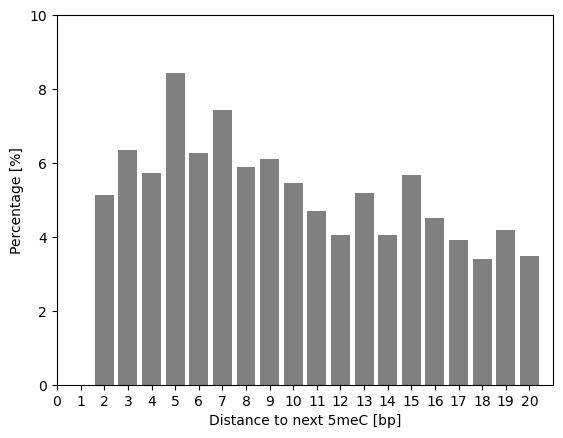

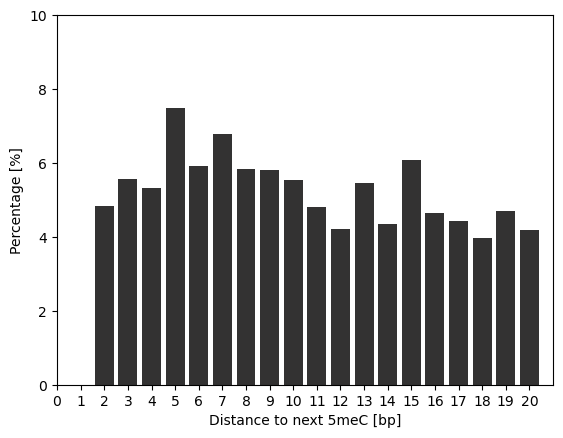

In [41]:
plot_CpG_CpG_dist(df_HCG_intersect)
plot_CpG_CpG_dist(df_HCG_intersect_random, c='#333232')

#### Rest of pipeline for the full genome

In [ ]:
## we can use same NOR and NDR file

In [42]:
promoters_sorted = data_path + 'ctcf.filtered.sorted.bed'
ndrfile = data_path + 'NDR.bed'
outfile = data_path + 'NDR.regions.intersect.bed'
intersect_bed(promoters_sorted, ndrfile, outfile)

In [43]:
promoters_sorted = data_path + 'ctcf.filtered.sorted.bed'
ndrfile = data_path + 'NOR.bed'
outfile = data_path + 'NOR.regions.intersect.bed'
intersect_bed(promoters_sorted, ndrfile, outfile)

In [44]:
def get_nuc_positions(infile, region='region'):
    column_names = ["trans_id", "refid", "gene_name", "chrom", f"{region}_start", f"{region}_end",
                    "TSS", "TES", "strand", "nuc_region_start_genome", "nuc_region_end_genome",
                    "nuc_start_promo_abs", "nuc_end_promo_abs", "nuc_start_promo_rel",
                    "nuc_end_promo_rel", "region_length"]
    
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
    
    with open(infile) as fin:
        for line in fin:
            line_s = line.strip().split('\t')

            chrom = line_s[0]            
            region_start = int(line_s[1])
            region_end = int(line_s[2])
            refid = line_s[3]
            gene_name = line_s[4]
            TSS = int(line_s[5])
            TES = int(line_s[6])
            strand = line_s[7]

            nuc_region_start = int(line_s[9])
            nuc_region_end = int(line_s[10])
            

            if nuc_region_start >= region_start and nuc_region_end <= region_end:    
                if strand == "+":
                    nuc_abs_start = nuc_region_start - region_start
                    nuc_abs_end = nuc_region_end - region_start
                    
                if strand == "-":
                    nuc_abs_end = region_end - nuc_region_start
                    nuc_abs_start = region_end - nuc_region_end

                rel_start = nuc_abs_start - 2000
                rel_end = nuc_abs_end - 2000

                info_dict["trans_id"].append(refid+'-'+str(region_start))
                info_dict["chrom"].append(chrom)
                info_dict[f"{region}_start"].append(region_start)
                info_dict[f"{region}_end"].append(region_end)
                info_dict["refid"].append(refid)
                info_dict["gene_name"].append(gene_name)
                info_dict["TSS"].append(TSS)
                info_dict["TES"].append(TES)
                info_dict["strand"].append(strand)
                
                info_dict["nuc_region_start_genome"].append(nuc_region_start)
                info_dict["nuc_region_end_genome"].append(nuc_region_end)
                
                info_dict["nuc_start_promo_abs"].append(nuc_abs_start)
                info_dict["nuc_end_promo_abs"].append(nuc_abs_end)
                
                info_dict["nuc_start_promo_rel"].append(rel_start)
                info_dict["nuc_end_promo_rel"].append(rel_end)
                
                info_dict["region_length"].append(rel_end - rel_start)
            
            else:
                # print('please check intersection file')
                pass

            
    # Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["refid"])), columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]  
        
    df = df.sort_values(by = ['chrom', f'{region}_start'], ascending=[True, True])
      
    return df

In [45]:
infile = data_path + 'NDR.regions.intersect.bed'
df_NDR_pos = get_nuc_positions(infile)

In [46]:
df_NDR_pos.head()

,trans_id,refid,gene_name,chrom,region_start,region_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_start_promo_abs,nuc_end_promo_abs,nuc_start_promo_rel,nuc_end_promo_rel,region_length
0,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,232,592,-1768,-1408,360
1,chr1-836657,chr1,chr1,chr1,836657,839657,837639,837657,-,838976,839176,481,681,-1519,-1319,200
2,chr1-848401,chr1,chr1,chr1,848401,851401,850401,850419,+,849036,849316,635,915,-1365,-1085,280
3,chr1-855286,chr1,chr1,chr1,855286,858286,856268,856286,-,856476,856796,1490,1810,-510,-190,320
4,chr1-863420,chr1,chr1,chr1,863420,866420,864402,864420,-,865616,865816,604,804,-1396,-1196,200


In [47]:
infile = data_path + 'NOR.regions.intersect.bed'
df_NOR_pos = get_nuc_positions(infile)

In [48]:
df_NOR_pos.head()

,trans_id,refid,gene_name,chrom,region_start,region_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_start_promo_abs,nuc_end_promo_abs,nuc_start_promo_rel,nuc_end_promo_rel,region_length
0,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,224,924,-1776,-1076,700
1,chr1-1058383,chr1,chr1,chr1,1058383,1061383,1060383,1060401,+,1060396,1060736,2013,2353,13,353,340
2,chr1-1173711,chr1,chr1,chr1,1173711,1176711,1175711,1175729,+,1174136,1176276,425,2565,-1575,565,2140
3,chr1-1296624,chr1,chr1,chr1,1296624,1299624,1297606,1297624,-,1297716,1298456,1168,1908,-832,-92,740
4,chr1-1370865,chr1,chr1,chr1,1370865,1373865,1371847,1371865,-,1372336,1372556,1309,1529,-691,-471,220


In [49]:
df_NDR_pos.shape, df_NOR_pos.shape

((47660, 16), (4099, 16))

In [50]:
df_NDR_pos['trans_id'].unique().shape

(44693,)

In [51]:
df_NOR_pos['trans_id'].unique().shape

(3846,)

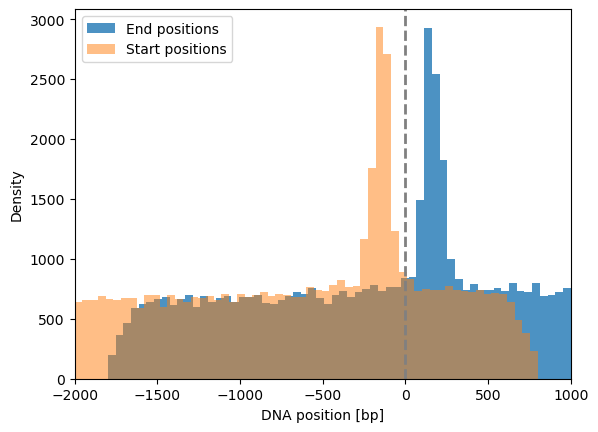

In [52]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure()

plt.hist(df_NDR_pos['nuc_end_promo_rel'],  bins = 60, histtype='bar', density=False, label="End positions", alpha = 0.8)  
plt.hist(df_NDR_pos['nuc_start_promo_rel'], bins = 60, histtype='bar', density=False, label="Start positions", alpha = 0.5)   

plt.xlabel("DNA position [bp]")
plt.ylabel("Density")

plt.xlim(-2000,1000)
plt.axvline(x=0, linestyle='dashed', linewidth=2, color='grey')
plt.legend()
plt.show()

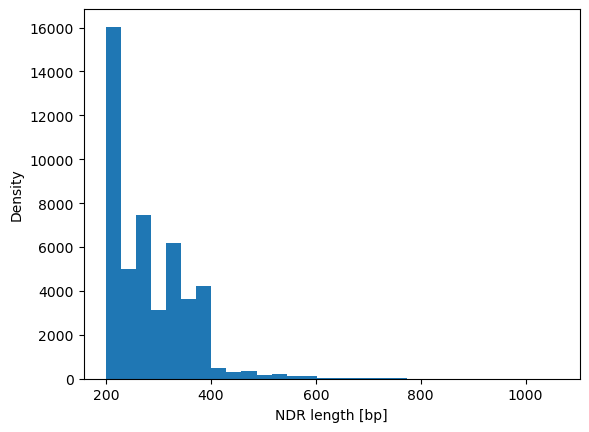

In [53]:
plt.figure()

plt.hist(df_NDR_pos['region_length'], bins=30, histtype='bar', density=False)  

plt.xlabel("NDR length [bp]")
plt.ylabel("Density")
plt.show()

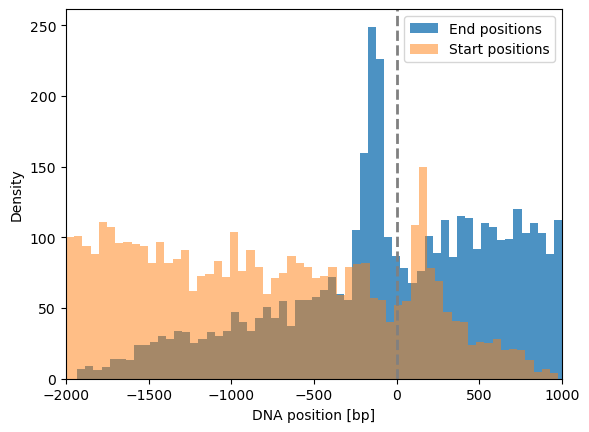

In [54]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure()

plt.hist(df_NOR_pos['nuc_end_promo_rel'],  bins = 60, histtype='bar', density=False, label="End positions", alpha = 0.8)  
plt.hist(df_NOR_pos['nuc_start_promo_rel'], bins = 60, histtype='bar', density=False, label="Start positions", alpha = 0.5)   

plt.xlabel("DNA position [bp]")
plt.ylabel("Density")

plt.xlim(-2000,1000)
plt.axvline(x=0, linestyle='dashed', linewidth=2, color='grey')
plt.legend()
plt.show()

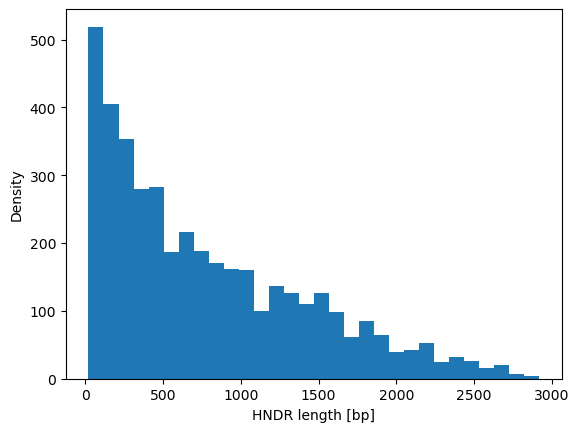

In [55]:
plt.figure()

plt.hist(df_NOR_pos['region_length'], bins=30, histtype='bar', density=False)  

plt.xlabel("HNDR length [bp]")
plt.ylabel("Density")
plt.show()

Text(0, 0.5, 'no of LNDRs')

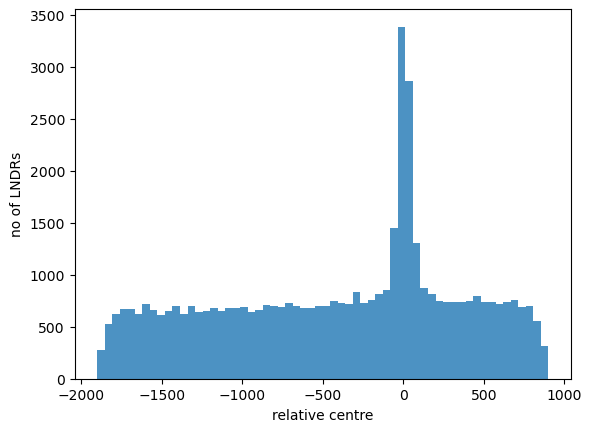

In [56]:
fig, ax = plt.subplots()

ax.hist((df_NDR_pos['nuc_start_promo_rel']+df_NDR_pos['nuc_end_promo_rel'])/2, 
           bins=60, histtype='bar', density=False, alpha=0.8)  

ax.set_xlabel("relative centre")
ax.set_ylabel("no of LNDRs")

Text(0, 0.5, 'no of HNDRs')

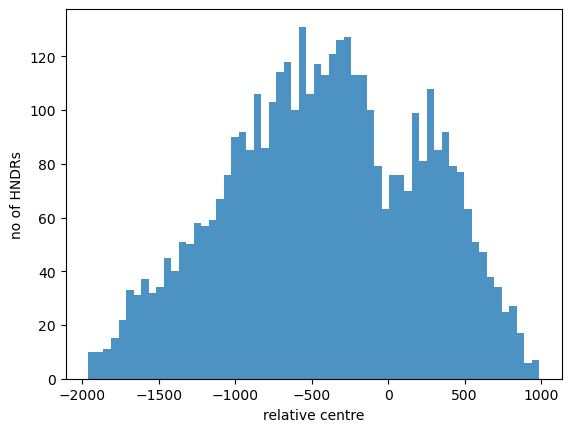

In [57]:
fig, ax = plt.subplots()

ax.hist((df_NOR_pos['nuc_start_promo_rel']+df_NOR_pos['nuc_end_promo_rel'])/2, 
           bins=60, histtype='bar', density=False, alpha=0.8)  

ax.set_xlabel("relative centre")
ax.set_ylabel("no of HNDRs")

max_clash 65.72379367720465
min_clash 0.0


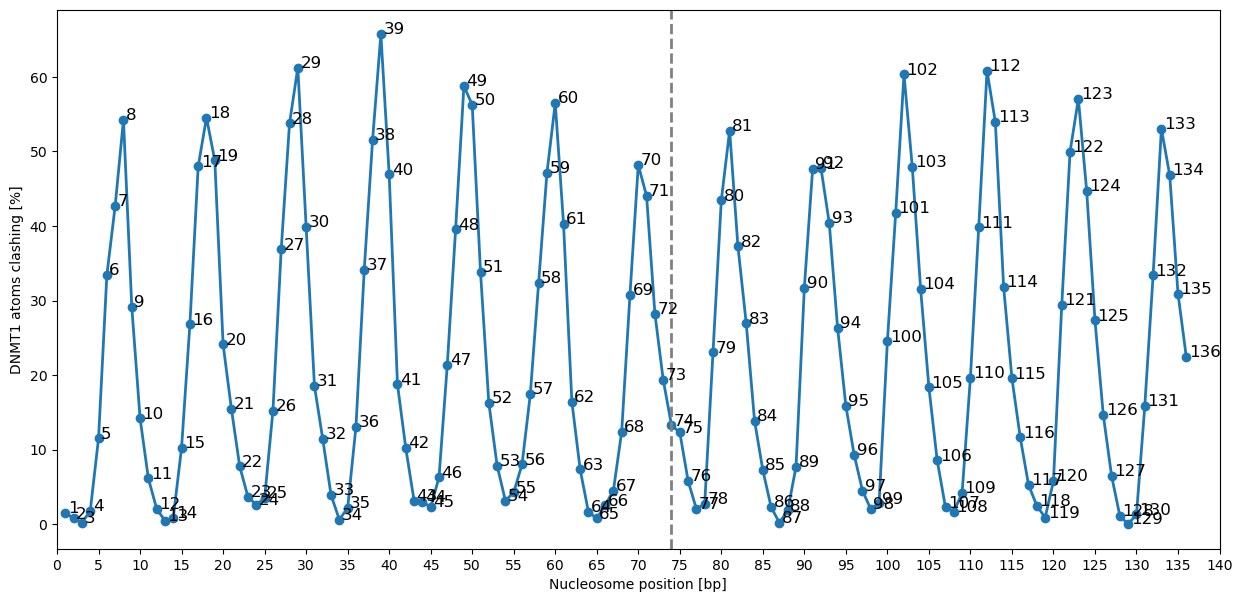

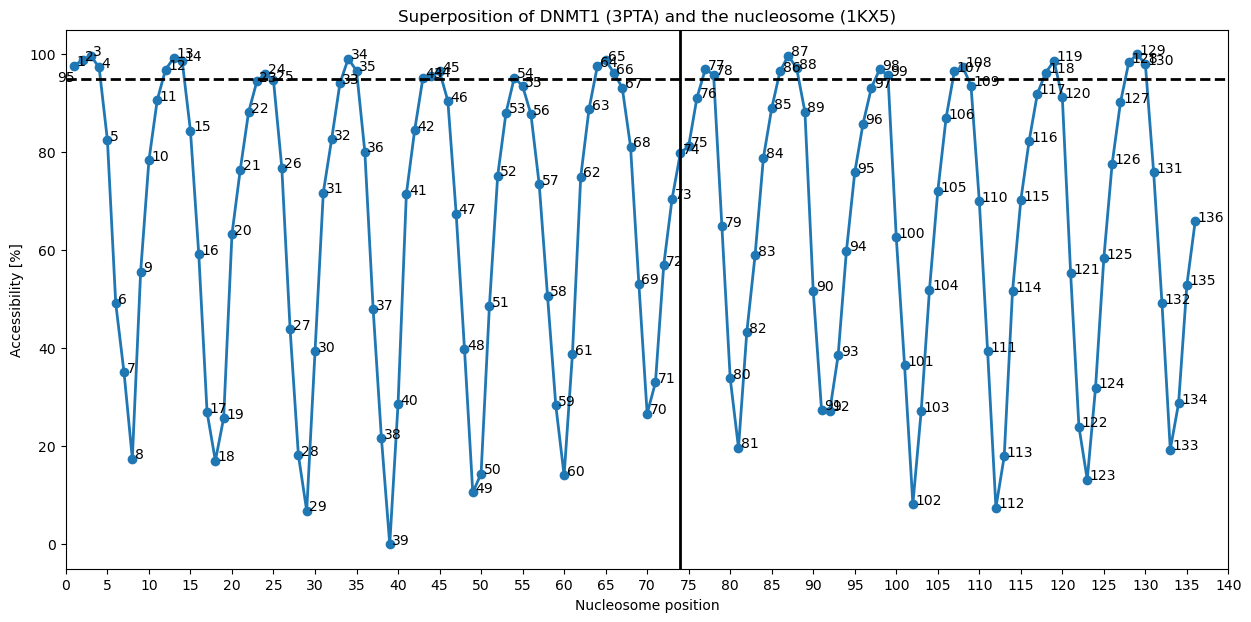

In [58]:
clash_dict_loc = steric_path + 'clash_dict'
info_dict_loc = steric_path + 'info_nbr_dict'
nome.plot_nbr_clashs(steric_path, clash_dict_loc, info_dict_loc)

In [59]:
promo_NDR_file = data_path + 'NDR.regions.intersect.bed'
promo_HCG_file = data_path + 'HCG.regions.intersect.bed'
outfile = data_path + 'regions.NDR.HCG.intersect.bed'
intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [60]:
promo_NDR_file = data_path + 'NDR.regions.intersect.bed'
promo_HCG_file = data_path + 'HCG.regions.intersect.random.bed'
outfile = data_path + 'regions.NDR.HCG.random.intersect.bed'
intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [61]:
promo_NDR_file = data_path + 'NOR.regions.intersect.bed'
promo_HCG_file = data_path + 'HCG.regions.intersect.bed'
outfile = data_path + 'regions.NOR.HCG.intersect.bed'
intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [62]:
promo_NDR_file = data_path + 'NOR.regions.intersect.bed'
promo_HCG_file = data_path + 'HCG.regions.intersect.random.bed'
outfile = data_path + 'regions.NOR.HCG.random.intersect.bed'
intersect_bed(promo_NDR_file, promo_HCG_file, outfile)

In [63]:
import pickle
import scipy
from scipy import stats

In [64]:
def get_nuc_pos_methylation(infile, region='region'):
    column_names = ["trans_id", "refid", "gene_name", "chrom", f"{region}_start", f"{region}_end",
                    "TSS", "TES", "strand", "nuc_region_start_genome", "nuc_region_end_genome",
                    "nuc_region_length", "meth_start_genome", "meth_end_genome", "meth_rate", "nt"]
    
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
    
    with open(infile, 'r') as fin:
        for line in tqdm(fin):
            line_s = line.strip().split('\t')

            chrom = line_s[0]            
            region_start = int(line_s[1])
            region_end = int(line_s[2])
            refid = line_s[3]
            gene_name = line_s[4]
            TSS = int(line_s[5])
            TES = int(line_s[6])
            strand = line_s[7]
            
            nuc_region_start = int(line_s[9])
            nuc_region_end = int(line_s[10])
            
            meth_start = int(line_s[20])
            meth_end = int(line_s[21])
            meth_rate = float(line_s[23])
            nt = line_s[25]
            
            if nuc_region_start >= region_start and nuc_region_end <= region_end:
                info_dict["trans_id"].append(refid + "-" + str(region_start))
                info_dict["chrom"].append(chrom)
                info_dict[f"{region}_start"].append(region_start)
                info_dict[f"{region}_end"].append(region_end)
                info_dict["refid"].append(refid)
                info_dict["gene_name"].append(gene_name)
                info_dict["TSS"].append(TSS)
                info_dict["TES"].append(TES)
                info_dict["strand"].append(strand)
                
                info_dict["nuc_region_start_genome"].append(nuc_region_start)
                info_dict["nuc_region_end_genome"].append(nuc_region_end)                
                info_dict["nuc_region_length"].append(nuc_region_end-nuc_region_start)
                
                info_dict["meth_start_genome"].append(meth_start)
                info_dict["meth_end_genome"].append(meth_end)
                info_dict["meth_rate"].append(meth_rate)
                info_dict["nt"].append(nt)

            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["refid"])), columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]  
        
    df = df.sort_values(by=['chrom', f'{region}_start'], ascending=[True, True])

    return df

In [65]:
def normalize_clash_dict(x_y_clash_dict):
    min_clash = min(x_y_clash_dict.values())
    max_clash = max(x_y_clash_dict.values())

    x_y_clash_dict_norm = {k: (float(v-min_clash)/float(max_clash-min_clash))*100 for k, v in x_y_clash_dict.items()}
    return x_y_clash_dict_norm

In [66]:
infile = steric_path + 'x_y_dict'
with open(infile, 'rb') as fin:
    x_y_clash_dict = pickle.load(fin)

x_y_clash_dict_norm = normalize_clash_dict(x_y_clash_dict)

meth_thres_range = [0, 10, 20]
clash_thres_range = [5, 10, 20, 50]

params = []
for clash_thres in clash_thres_range:
    for meth_thres in meth_thres_range:
        k = "c" + str(clash_thres) + "m" + str(meth_thres)
        params.append(k)

In [67]:
infile = data_path + 'regions.NDR.HCG.intersect.bed'
df_NDR = get_nuc_pos_methylation(infile)

infile = data_path + 'regions.NDR.HCG.random.intersect.bed'
df_NDR_random = get_nuc_pos_methylation(infile)

1330486it [00:05, 250155.27it/s]
1330486it [00:05, 246969.92it/s]


In [68]:
df_NDR.shape, df_NDR_random.shape

((1140058, 16), (1140058, 16))

In [69]:
df_NDR.head()

,trans_id,refid,gene_name,chrom,region_start,region_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_region_length,meth_start_genome,meth_end_genome,meth_rate,nt
0,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,360,601076,601077,0.0,C
1,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,360,601548,601549,0.0,C
2,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,360,601581,601582,0.0,C
3,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,360,601582,601583,0.0,G
4,chr1-600428,chr1,chr1,chr1,600428,603428,601410,601428,-,602836,603196,360,601634,601635,50.0,C


In [70]:
infile = data_path + 'regions.NOR.HCG.intersect.bed'
df_NOR = get_nuc_pos_methylation(infile)

infile = data_path + 'regions.NOR.HCG.random.intersect.bed'
df_NOR_random = get_nuc_pos_methylation(infile)

8096567it [00:18, 429727.18it/s]
8096567it [00:18, 431169.50it/s]


In [71]:
df_NOR.shape, df_NOR_random.shape

((134472, 16), (134472, 16))

In [72]:
df_NOR.head()

,trans_id,refid,gene_name,chrom,region_start,region_end,TSS,TES,strand,nuc_region_start_genome,nuc_region_end_genome,nuc_region_length,meth_start_genome,meth_end_genome,meth_rate,nt
0,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,700,954837,954838,0.00,G
1,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,700,954849,954850,0.00,G
2,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,700,954852,954853,100.00,G
3,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,700,954867,954868,66.67,G
4,chr1-954812,chr1,chr1,chr1,954812,957812,956812,956830,+,955036,955736,700,955683,955684,0.00,C


In [73]:
def make_sliding_windows_file(df_promo_nuc_WGBS, x_y_clash_dict_norm, mask=True, region='region'):
    if mask:
        pos_true = pd.DataFrame([df_promo_nuc_WGBS['meth_start_genome'] > df_promo_nuc_WGBS['nuc_region_start_genome'], 
                                 df_promo_nuc_WGBS['meth_start_genome'] < df_promo_nuc_WGBS['nuc_region_end_genome'], 
                                 df_promo_nuc_WGBS['strand'] == '+']).T.all(axis=1)
        neg_true = pd.DataFrame([df_promo_nuc_WGBS['meth_end_genome'] > df_promo_nuc_WGBS['nuc_region_start_genome'], 
                                 df_promo_nuc_WGBS['meth_end_genome'] < df_promo_nuc_WGBS['nuc_region_end_genome'], 
                                 df_promo_nuc_WGBS['strand'] == '-']).T.all(axis=1)
        df_promo_nuc_WGBS = df_promo_nuc_WGBS[np.logical_or(pos_true, neg_true)]


    column_names = ["trans_id", "refid", "NOR_nbr", "window_nbr", "nbr_meth_CpGs", 
                    "nuc_region_length", "nuc_rel_center", "meth_rates_window"] 
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
        
    all_nuc_pos = x_y_clash_dict_norm.keys()
    nbr_bases_nuc = len(all_nuc_pos)
    
    all_trans_ids = list(set(list(df_promo_nuc_WGBS["trans_id"])))
    
    c = 0
    for trans_id in tqdm(all_trans_ids):
        refid = trans_id.split("-")[0]
        c += 1
        
        df_WGBS_tmp = df_promo_nuc_WGBS.loc[df_promo_nuc_WGBS["trans_id"] == trans_id]
        
        NOR_number = 1
        nuc_region_starts = list(set(list(df_WGBS_tmp["nuc_region_start_genome"])))
        for NOR_start in nuc_region_starts:
            df_NOR_tmp = df_WGBS_tmp.loc[df_WGBS_tmp["nuc_region_start_genome"] == NOR_start]
            
            start = NOR_start
            win_nbr = 1
                    
            list_meth_positions = list(df_NOR_tmp["meth_start_genome"])
            list_meth_rates = list(df_NOR_tmp["meth_rate"])
            meth_dict_promoter = dict(zip(list_meth_positions, list_meth_rates))
    
            NOR_end = list(df_NOR_tmp["nuc_region_end_genome"])[0]

            assert df_NOR_tmp[f"{region}_start"].unique().shape[0] == 1
            region_start = df_NOR_tmp[f"{region}_start"].unique()[0]
            assert df_NOR_tmp[f"{region}_end"].unique().shape[0] == 1
            region_end = df_NOR_tmp[f"{region}_end"].unique()[0]
            assert df_NOR_tmp[f"strand"].unique().shape[0] == 1
            strand = df_NOR_tmp[f"strand"].unique()[0]

            if NOR_start >= region_start and NOR_end <= region_end:    
                if strand == "+":
                    nuc_abs_start = NOR_start - region_start
                    nuc_abs_end = NOR_end - region_start
                    
                if strand == "-":
                    nuc_abs_end = region_end - NOR_start
                    nuc_abs_start = region_end - NOR_end

                rel_start = nuc_abs_start - 2000
                rel_end = nuc_abs_end - 2000
            else:
                raise Exception("problem")
            
            while start + nbr_bases_nuc - 1 <= NOR_end:
                #get relative and absolute position+methylation
                window_start = start
                window_end = window_start+nbr_bases_nuc-1
                
                meth_in_window_tmp = dict()
                for meth_start_genome in meth_dict_promoter.keys():
                    if (window_start <= meth_start_genome) & (meth_start_genome <= window_end):
                        rel_pos = meth_start_genome-window_start+1
                        
                        meth_rate = meth_dict_promoter[meth_start_genome]
                        meth_in_window_tmp[rel_pos] = meth_rate
                
                if len(meth_in_window_tmp) != 0:
                    #exp
                    info_dict["trans_id"].append(trans_id)
                    info_dict["refid"].append(refid)
                    info_dict["NOR_nbr"].append(NOR_number)
                    info_dict["window_nbr"].append(win_nbr)
                    info_dict["nbr_meth_CpGs"].append(len(meth_in_window_tmp.keys()))
                    info_dict["nuc_region_length"].append(np.abs(NOR_end-NOR_start)+1)
                    info_dict["nuc_rel_center"].append((rel_start+rel_end)/2)
                    info_dict["meth_rates_window"].append(meth_in_window_tmp)
                
                start += 1
                win_nbr += 1
        
            NOR_number += 1
                
                
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["trans_id"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [75]:
## takes time try mask = False
# df_NDR_sliding_windows = make_sliding_windows_file(df_NDR[df_NDR['chrom'].isin(['chr1', 
#                                                                                 'chr2', 
#                                                                                 'chr3'])], 
#                                                    x_y_clash_dict_norm)
df_NDR_sliding_windows = make_sliding_windows_file(df_NDR, x_y_clash_dict_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35855/35855 [07:39<00:00, 78.07it/s]


In [76]:
((df_NDR['chrom'].isin(['chr1', 'chr2', 'chr3'])) == (df_NDR_random['chrom'].isin(['chr1', 'chr2', 'chr3']))).all()

True

In [77]:
# df_NDR_sliding_windows_random = make_sliding_windows_file(df_NDR_random[df_NDR['chrom'].isin(['chr1', 'chr2', 'chr3'])], x_y_clash_dict_norm)
df_NDR_sliding_windows_random = make_sliding_windows_file(df_NDR_random, x_y_clash_dict_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35855/35855 [07:39<00:00, 78.04it/s]


In [78]:
df_NDR_sliding_windows.shape, df_NDR_sliding_windows_random.shape

((4422481, 8), (4422481, 8))

In [79]:
df_NDR_sliding_windows.head()

,trans_id,refid,NOR_nbr,window_nbr,nbr_meth_CpGs,nuc_region_length,nuc_rel_center,meth_rates_window
0,chr10-115717072,chr10,1,1,4,401,-522.0,"{19: 0.0, 20: 0.0, 45: 0.0, 75: 40.0}"
1,chr10-115717072,chr10,1,2,4,401,-522.0,"{18: 0.0, 19: 0.0, 44: 0.0, 74: 40.0}"
2,chr10-115717072,chr10,1,3,4,401,-522.0,"{17: 0.0, 18: 0.0, 43: 0.0, 73: 40.0}"
3,chr10-115717072,chr10,1,4,4,401,-522.0,"{16: 0.0, 17: 0.0, 42: 0.0, 72: 40.0}"
4,chr10-115717072,chr10,1,5,4,401,-522.0,"{15: 0.0, 16: 0.0, 41: 0.0, 71: 40.0}"


In [80]:
## takes time try mask = False
# df_NOR_sliding_windows = make_sliding_windows_file(df_NOR[df_NOR['chrom'].isin(['chr1', 'chr2', 'chr3'])], x_y_clash_dict_norm)
df_NOR_sliding_windows = make_sliding_windows_file(df_NOR, x_y_clash_dict_norm)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3304/3304 [00:15<00:00, 208.21it/s]


In [81]:
((df_NOR['chrom'].isin(['chr1', 'chr2', 'chr3'])) == (df_NOR_random['chrom'].isin(['chr1', 'chr2', 'chr3']))).all()

True

In [82]:
# df_NOR_sliding_windows_random = make_sliding_windows_file(df_NOR_random[df_NOR['chrom'].isin(['chr1', 'chr2', 'chr3'])], x_y_clash_dict_norm)
df_NOR_sliding_windows_random = make_sliding_windows_file(df_NOR_random, x_y_clash_dict_norm)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3304/3304 [00:15<00:00, 213.48it/s]


In [83]:
df_NOR_sliding_windows.shape, df_NOR_sliding_windows_random.shape

((1446734, 8), (1446734, 8))

In [84]:
df_NOR_sliding_windows.head()

,trans_id,refid,NOR_nbr,window_nbr,nbr_meth_CpGs,nuc_region_length,nuc_rel_center,meth_rates_window
0,chr16-9592959,chr16,1,236,1,421,-1684.0,{136: 20.0}
1,chr16-9592959,chr16,1,237,1,421,-1684.0,{135: 20.0}
2,chr16-9592959,chr16,1,238,1,421,-1684.0,{134: 20.0}
3,chr16-9592959,chr16,1,239,1,421,-1684.0,{133: 20.0}
4,chr16-9592959,chr16,1,240,1,421,-1684.0,{132: 20.0}


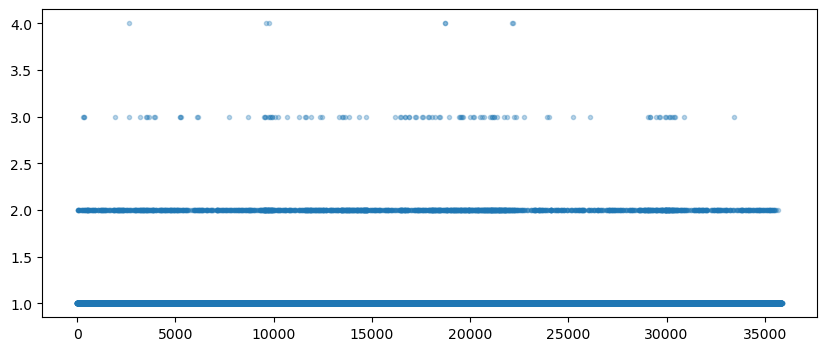

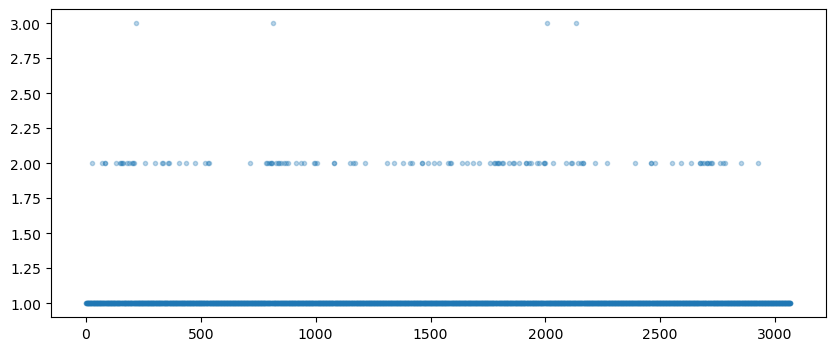

In [85]:
groups = df_NDR_sliding_windows.groupby(by='trans_id')

nor_nbr = []
for group in groups:
    nor_nbr.append(group[1]['NOR_nbr'].unique().shape[0])

plt.figure(figsize=(10,4))
plt.scatter(np.arange(df_NDR_sliding_windows['trans_id'].unique().shape[0]), nor_nbr, marker='.', alpha=0.3)

groups = df_NOR_sliding_windows.groupby(by='trans_id')

nor_nbr = []
for group in groups:
    nor_nbr.append(group[1]['NOR_nbr'].unique().shape[0])

plt.figure(figsize=(10,4))
plt.scatter(np.arange(df_NOR_sliding_windows['trans_id'].unique().shape[0]), nor_nbr, marker='.', alpha=0.3)

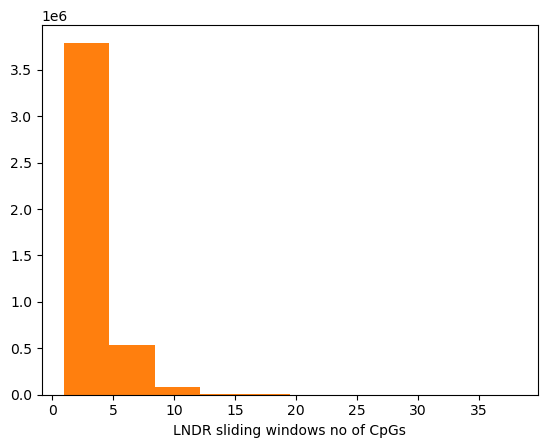

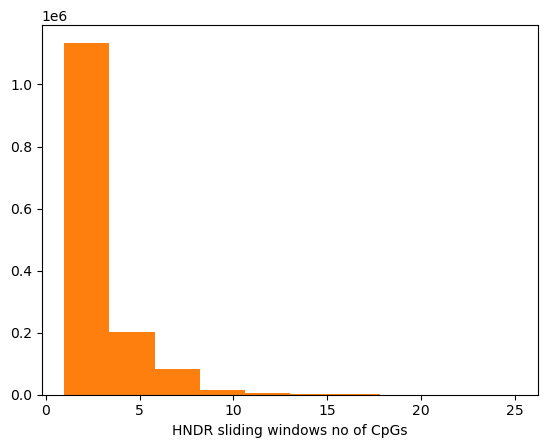

In [86]:
plt.figure()
_ = plt.hist(df_NDR_sliding_windows['nbr_meth_CpGs'])
_ = plt.hist(df_NDR_sliding_windows_random['nbr_meth_CpGs'])
_ = plt.xlabel('LNDR sliding windows no of CpGs')

plt.figure()
_ = plt.hist(df_NOR_sliding_windows['nbr_meth_CpGs'])
_ = plt.hist(df_NOR_sliding_windows_random['nbr_meth_CpGs'])
_ = plt.xlabel('HNDR sliding windows no of CpGs')

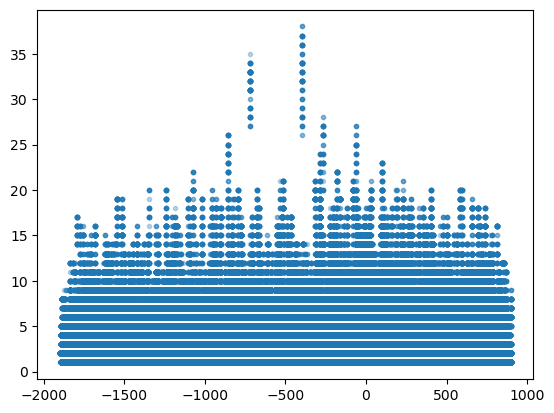

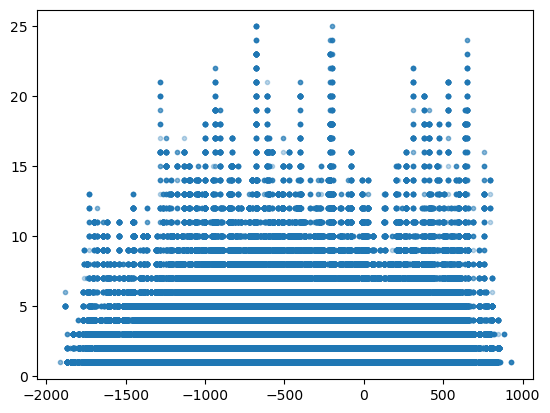

In [87]:
plt.figure()
plt.scatter(df_NDR_sliding_windows['nuc_rel_center'], df_NDR_sliding_windows['nbr_meth_CpGs'], 
            marker='.', alpha=0.3)

plt.figure()
plt.scatter(df_NOR_sliding_windows['nuc_rel_center'], df_NOR_sliding_windows['nbr_meth_CpGs'], 
            marker='.', alpha=0.3)


In [88]:
import re

def calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_in_window_tmp, meth_thres, clash_thres):    
    count_ident = 0
    cpg_positions = meth_in_window_tmp.keys()
    for meth_pos in cpg_positions:
        meth_rate = meth_in_window_tmp[meth_pos]
        clash_perc = x_y_clash_dict_norm[meth_pos] 
        
        if meth_rate > meth_thres:
            if clash_perc <= clash_thres:
                count_ident += 1
        else:
            if clash_perc > clash_thres:
                count_ident += 1
                
    nbr_cpgs = len(cpg_positions)
    perc_exp_clash_ident = float(count_ident)/float(nbr_cpgs)
    
    return perc_exp_clash_ident

def calc_score_lists(df_sliding_windows, x_y_clash_dict_norm, params):
    column_names = ["refid_NOR", "trans_id", "refid", "NOR_nbr", "window_nbr", "nbr_CpGs", "nuc_rel_center", "nuc_region_length"] + params
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
        
    all_refids = list(df_sliding_windows["refid"])
    all_NOR_nbrs = list(df_sliding_windows["NOR_nbr"])
    refid_NORs = []
    for ref, nor in zip(all_refids, all_NOR_nbrs):
        refid_NORs.append(str(ref)+"-"+str(nor))
    
    info_dict["refid_NOR"].extend(refid_NORs)
    info_dict["trans_id"].extend(list(df_sliding_windows["trans_id"]))
    info_dict["refid"].extend(all_refids)
    info_dict["NOR_nbr"].extend(all_NOR_nbrs)
    info_dict["window_nbr"].extend( list(df_sliding_windows["window_nbr"]))
    info_dict["nbr_CpGs"].extend(list(df_sliding_windows["nbr_meth_CpGs"])  )
    info_dict["nuc_region_length"].extend(list(df_sliding_windows["nuc_region_length"]))
    info_dict["nuc_rel_center"].extend(list(df_sliding_windows["nuc_rel_center"]))

    all_scores =  list(df_sliding_windows["meth_rates_window"]) #{34: 0.0, 35: 0.0,...}
    c = 0
    for row_df in tqdm(range(len(all_scores))):
        c += 1
        
        # meth_rates_window = ast.literal_eval(all_scores[row_df])
        meth_rates_window = all_scores[row_df]
    
        for param_str in params:
            clash_thres = float(re.findall(r'\d+', param_str)[0]) #c5m0
            meth_thres = float(re.findall(r'\d+', param_str)[1])
            
            perc_clash_ident = calc_perc_exp_clash_ident(x_y_clash_dict_norm, meth_rates_window, meth_thres, clash_thres)
            info_dict[param_str].append(perc_clash_ident)
            
    #Built dataframe 
    df_scores = pd.DataFrame(0, index = np.arange(len(info_dict[column_names[0]])),columns = column_names)
    for feat in column_names:
        df_scores[feat] = info_dict[feat]

    return df_scores

In [89]:
df_NDR_score_exp = calc_score_lists(df_NDR_sliding_windows, x_y_clash_dict_norm, params)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422481/4422481 [02:23<00:00, 30895.05it/s]


In [90]:
df_NDR_score_random = calc_score_lists(df_NDR_sliding_windows_random, x_y_clash_dict_norm, params)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422481/4422481 [02:20<00:00, 31429.09it/s]


In [91]:
df_NDR_score_exp.shape, df_NDR_score_random.shape

((4422481, 20), (4422481, 20))

In [92]:
df_NDR_score_exp.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_rel_center,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,chr10-1,chr10-115717072,chr10,1,1,4,-522.0,401,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.75,0.75,0.50,0.50,0.50
1,chr10-1,chr10-115717072,chr10,1,2,4,-522.0,401,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.75,0.75
2,chr10-1,chr10-115717072,chr10,1,3,4,-522.0,401,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.75,0.75
3,chr10-1,chr10-115717072,chr10,1,4,4,-522.0,401,0.75,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.50,0.50,0.50,0.50
4,chr10-1,chr10-115717072,chr10,1,5,4,-522.0,401,0.75,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.50,0.00,0.00,0.00


In [93]:
df_NOR_score_exp = calc_score_lists(df_NOR_sliding_windows, x_y_clash_dict_norm, params)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1446734/1446734 [00:45<00:00, 31539.79it/s]


In [94]:
df_NOR_score_random = calc_score_lists(df_NOR_sliding_windows_random, x_y_clash_dict_norm, params)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1446734/1446734 [00:45<00:00, 31629.62it/s]


In [95]:
df_NOR_score_exp.shape, df_NOR_score_random.shape

((1446734, 20), (1446734, 20))

In [96]:
df_NOR_score_exp.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_rel_center,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,chr16-1,chr16-9592959,chr16,1,236,1,-1684.0,421,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,chr16-1,chr16-9592959,chr16,1,237,1,-1684.0,421,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,chr16-1,chr16-9592959,chr16,1,238,1,-1684.0,421,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,chr16-1,chr16-9592959,chr16,1,239,1,-1684.0,421,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,chr16-1,chr16-9592959,chr16,1,240,1,-1684.0,421,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [97]:
def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_p_vals_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["nbr_CpGs", "parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    nbr_CpGs_list = list(set(list(df_scores_EXP["nbr_CpGs"])))

    for nbr_CpGs in nbr_CpGs_list:
        df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP["nbr_CpGs"] == nbr_CpGs]
        df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND["nbr_CpGs"] == nbr_CpGs]
                    
        for p in range(len(params)):
            par_name = params[p]
            EXP_scores = list(df_scores_EXP_tmp[par_name])
            RAND_scores = list(df_scores_RAND_tmp[par_name])
            
            info_dict["nbr_CpGs"].append(nbr_CpGs)
            info_dict["parameter"].append(par_name)
            
            info_dict["N_EXP"].append(len(EXP_scores))
            info_dict["N_RAND"].append(len(RAND_scores))
            
            info_dict["mean_EXP"].append(np.mean(EXP_scores))
            info_dict["median_EXP"].append(np.median(EXP_scores))
            info_dict["std_EXP"].append(np.std(EXP_scores))
            
            info_dict["mean_RAND"].append(np.mean(RAND_scores))
            info_dict["median_RAND"].append(np.median(RAND_scores))
            info_dict["std_RAND"].append(np.std(RAND_scores))
            
            #EFFECT SIZE
            cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
            info_dict["cohens_d"].append(cohens_d)
            
            #STAT TESTS
            #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
            pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
            pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
            
            #students t
            ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
            t_stat = ttest_res[0]
            p_val_ttest = float(ttest_res[1])/2.0
            
            #ranksums, kstest
            ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
            ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
    
            info_dict["is_normal_EXP"].append(pval_normal_EXP)
            info_dict["is_normal_RAND"].append(pval_normal_RAND)
            info_dict["pval_ttest"].append(p_val_ttest)
            info_dict["t_stat"].append(t_stat)
            info_dict["pval_ranksums"].append(ranksums)
            info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["nbr_CpGs"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [98]:
df_NDR_pvalues = make_df_p_vals_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/tmp/ipykernel_704034/3421195670.py:62: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy

In [99]:
df_NDR_pvalues

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m0,1568269,1568269,0.494093,0.000000,0.499965,0.466124,0.000000,0.498851,0.056003,0.0,0.0,0.000000e+00,49.591490,0.000000e+00,0.000000e+00
1,1,c5m10,1568269,1568269,0.495294,0.000000,0.499978,0.467153,0.000000,0.498920,0.056346,0.0,0.0,0.000000e+00,49.894951,0.000000e+00,0.000000e+00
2,1,c5m20,1568269,1568269,0.522772,1.000000,0.499481,0.488611,0.000000,0.499870,0.068367,0.0,0.0,0.000000e+00,60.539716,0.000000e+00,0.000000e+00
3,1,c10m0,1568269,1568269,0.496525,0.000000,0.499988,0.478156,0.000000,0.499523,0.036757,0.0,0.0,1.204477e-232,32.548447,1.218282e-174,2.867800e-230
4,1,c10m10,1568269,1568269,0.497310,0.000000,0.499993,0.478821,0.000000,0.499551,0.036995,0.0,0.0,1.208584e-235,32.759760,6.697040e-177,2.803273e-233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,38,c20m10,3,3,0.535088,0.500000,0.089456,0.473684,0.526316,0.074432,0.746193,-1.0,-1.0,2.491483e-01,0.746203,8.272593e-01,1.000000e+00
452,38,c20m20,3,3,0.526316,0.500000,0.077472,0.473684,0.526316,0.074432,0.692811,-1.0,-1.0,2.633012e-01,0.692820,8.272593e-01,1.000000e+00
453,38,c50m0,3,3,0.587719,0.578947,0.012405,0.447368,0.447368,0.021487,7.999544,-1.0,-1.0,1.606348e-03,8.000000,4.953461e-02,1.000000e-01
454,38,c50m10,3,3,0.315789,0.315789,0.021487,0.447368,0.447368,0.021487,-6.123439,-1.0,-1.0,1.801116e-03,-6.123724,4.953461e-02,1.000000e-01


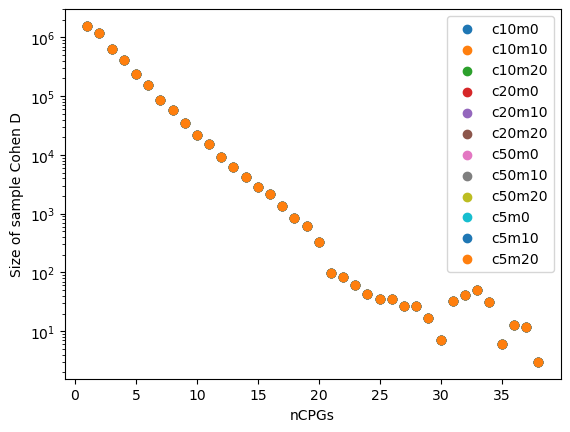

In [100]:
groups = df_NDR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)
plt.legend()
plt.xlabel('nCPGs')
plt.ylabel('Size of sample Cohen D')
plt.yscale('log')

In [101]:
df_NOR_pvalues = make_df_p_vals_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [102]:
df_NOR_pvalues

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m0,527531,527531,0.459611,0.00,0.498366,0.466318,0.00,0.498864,-1.345066e-02,0.000000,0.000000,2.458889e-12,-6.908009e+00,2.432219e-09,9.860064e-11
1,1,c5m10,527531,527531,0.460299,0.00,0.498421,0.467789,0.00,0.498961,-1.501849e-02,0.000000,0.000000,6.139423e-15,-7.713220e+00,2.694547e-11,2.800847e-13
2,1,c5m20,527531,527531,0.480343,0.00,0.499613,0.491008,0.00,0.499919,-2.133948e-02,0.000000,0.000000,2.999693e-28,-1.095957e+01,2.381648e-21,1.736097e-26
3,1,c10m0,527531,527531,0.473917,0.00,0.499319,0.478361,0.00,0.499532,-8.896888e-03,0.000000,0.000000,2.447311e-06,-4.569278e+00,7.731787e-05,5.976666e-05
4,1,c10m10,527531,527531,0.474363,0.00,0.499342,0.479301,0.00,0.499571,-9.886917e-03,0.000000,0.000000,1.910090e-07,-5.077739e+00,1.119640e-05,5.163094e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,25,c20m10,16,16,0.535000,0.52,0.104762,0.535000,0.54,0.119059,-9.900391e-16,0.565668,0.527998,5.000000e-01,-2.711358e-15,8.950545e-01,1.000000e+00
296,25,c20m20,16,16,0.552500,0.56,0.069597,0.542500,0.54,0.128038,9.704185e-02,0.438828,0.662032,3.963871e-01,2.657626e-01,9.399141e-01,7.164117e-01
297,25,c50m0,16,16,0.415000,0.46,0.119059,0.505000,0.54,0.120727,-7.506456e-01,0.477859,0.995182,2.430098e-02,-2.055745e+00,7.044043e-02,2.145346e-01
298,25,c50m10,16,16,0.415000,0.46,0.119059,0.505000,0.54,0.120727,-7.506456e-01,0.477859,0.995182,2.430098e-02,-2.055745e+00,7.044043e-02,2.145346e-01


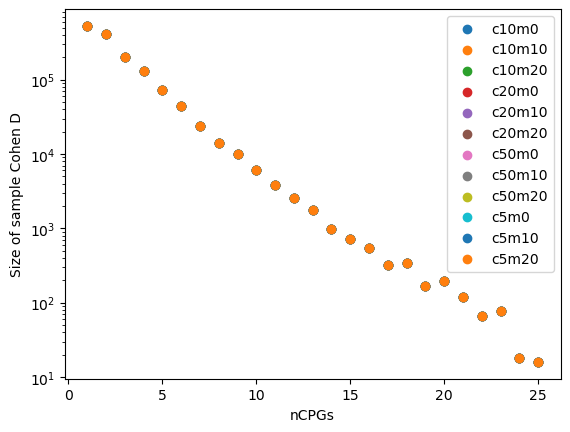

In [103]:
groups = df_NOR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)
plt.legend()
plt.xlabel('nCPGs')
plt.ylabel('Size of sample Cohen D')
plt.yscale('log')

In [104]:
def plot_nbr_CpGs_cohensd(df_values, params):
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))

    for par_name in params:
        
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_cohens_d_vals = list(df_values_tmp["cohens_d"])
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals, y_cohens_d_vals, linestyle="-", color=c, marker=m, markersize=ms, label=par_name)
    
    
    plt.axhline(y=0.2, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.5, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.8, linewidth=1, color = '#2C3E50',linestyle='--')
    
    e = 0.02
    ax.text(-1.8,0.2+e,"Small ES")
    ax.text(-1.8,0.5+e,"Medium ES")
    ax.text(-1.8,0.8+e,"Large ES")

    ax.set_ylabel("Cohen's d")
    ax.set_xlabel("Number of CpGs in sliding window")   

    plt.xlim(-2,35)
    plt.ylim(-3,3)

    legend = ax.legend(loc="lower left",ncol=4,frameon = 1,prop={'size':14})
    legend.get_frame().set_facecolor('white')

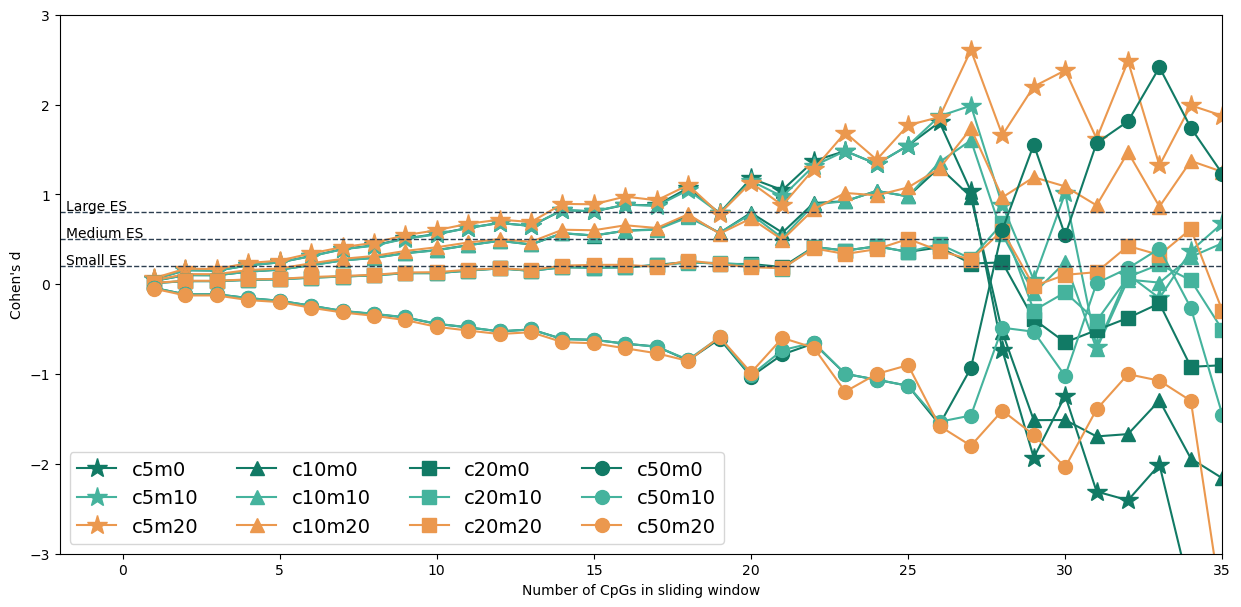

In [105]:
plot_nbr_CpGs_cohensd(df_NDR_pvalues, params)

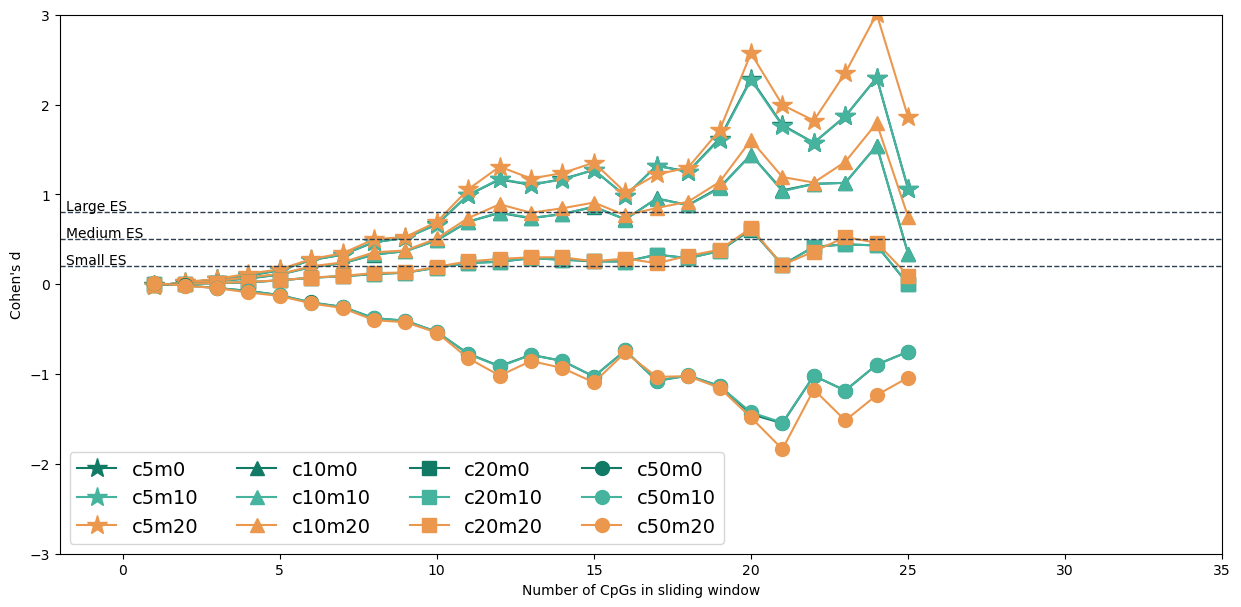

In [106]:
plot_nbr_CpGs_cohensd(df_NOR_pvalues, params)

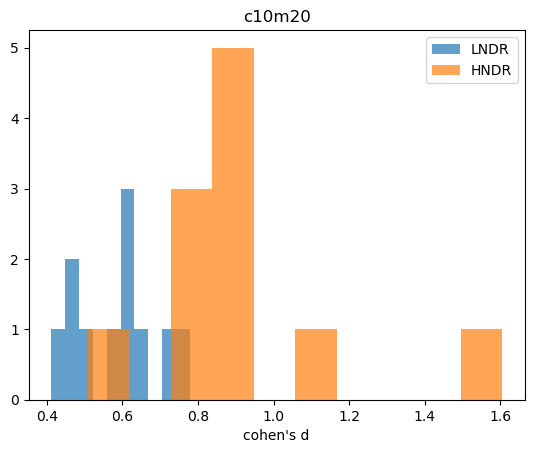

In [120]:
param = 'c10m20'
plt.hist(df_NDR_pvalues[np.logical_and(df_NDR_pvalues['nbr_CpGs'].between(10,20), df_NDR_pvalues['parameter'] == param)]['cohens_d'], label='LNDR', alpha=0.7)
plt.hist(df_NOR_pvalues[np.logical_and(df_NOR_pvalues['nbr_CpGs'].between(10,20), df_NOR_pvalues['parameter'] == param)]['cohens_d'], label='HNDR', alpha=0.7)
plt.legend()
plt.title(param)
plt.xlabel('cohen\'s d')  
plt.show()

In [113]:
df_NDR_pvalues[np.logical_and(df_NDR_pvalues['nbr_CpGs'].between(0,20), df_NDR_pvalues['parameter'] == 'c5m10')]

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
1,1,c5m10,1568269,1568269,0.495294,0.000000,0.499978,0.467153,0.000000,0.498920,0.056346,0.000000e+00,0.000000e+00,0.000000e+00,49.894951,0.000000e+00,0.000000e+00
13,2,c5m10,1184553,1184553,0.523752,0.500000,0.387625,0.465846,0.500000,0.352021,0.156397,0.000000e+00,0.000000e+00,0.000000e+00,120.362361,0.000000e+00,0.000000e+00
25,3,c5m10,626925,626925,0.514494,0.666667,0.322015,0.468004,0.333333,0.288844,0.151987,0.000000e+00,0.000000e+00,0.000000e+00,85.094321,0.000000e+00,0.000000e+00
37,4,c5m10,410116,410116,0.525241,0.500000,0.291781,0.468267,0.500000,0.249548,0.209859,0.000000e+00,0.000000e+00,0.000000e+00,95.031254,0.000000e+00,0.000000e+00
49,5,c5m10,234213,234213,0.528646,0.600000,0.263400,0.469240,0.400000,0.223602,0.243157,0.000000e+00,0.000000e+00,0.000000e+00,83.210420,0.000000e+00,0.000000e+00
61,6,c5m10,152085,152085,0.539503,0.500000,0.247436,0.468947,0.500000,0.202963,0.311787,0.000000e+00,5.328203e-228,0.000000e+00,85.977740,0.000000e+00,0.000000e+00
73,7,c5m10,87701,87701,0.547055,0.571429,0.228611,0.465838,0.428571,0.187078,0.388823,0.000000e+00,2.140392e-91,0.000000e+00,81.421436,0.000000e+00,0.000000e+00
85,8,c5m10,57966,57966,0.551138,0.625000,0.218002,0.465920,0.500000,0.177154,0.429026,5.118659e-242,1.082308e-44,0.000000e+00,73.038754,0.000000e+00,0.000000e+00
97,9,c5m10,35100,35100,0.561618,0.555556,0.203572,0.467575,0.444444,0.165965,0.506356,1.693893e-129,9.912410e-16,0.000000e+00,67.079586,0.000000e+00,0.000000e+00
109,10,c5m10,22238,22238,0.564205,0.600000,0.196364,0.465163,0.500000,0.158266,0.555368,4.000768e-74,2.644401e-14,0.000000e+00,58.560705,0.000000e+00,0.000000e+00


In [110]:
df_NOR_pvalues[np.logical_and(df_NOR_pvalues['nbr_CpGs'] >= 10, df_NOR_pvalues['parameter'] == 'c5m10')]

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
109,10,c5m10,6116,6116,0.597940,0.600000,0.234923,0.466203,0.500000,0.153179,0.664297,1.716085e-77,2.544247e-08,2.500096e-278,36.732293,1.035586e-296,0.000000e+00
121,11,c5m10,3783,3783,0.654243,0.727273,0.199102,0.476750,0.454545,0.155035,0.994717,1.084690e-80,4.907183e-02,0.000000e+00,43.256122,0.000000e+00,0.000000e+00
133,12,c5m10,2548,2548,0.669054,0.666667,0.177215,0.482797,0.500000,0.138118,1.172353,5.302585e-70,6.780018e-04,0.000000e+00,41.837022,0.000000e+00,7.579072e-307
145,13,c5m10,1746,1746,0.669090,0.692308,0.176766,0.493436,0.461538,0.137291,1.109875,1.857465e-53,3.802955e-01,1.610290e-204,32.783805,2.238844e-206,8.555590e-198
157,14,c5m10,994,994,0.672463,0.714286,0.172857,0.494036,0.500000,0.130503,1.165036,6.659146e-31,9.287704e-01,3.112587e-127,25.959819,1.113097e-127,4.072240e-127
169,15,c5m10,724,724,0.671823,0.666667,0.164305,0.487017,0.466667,0.122576,1.274961,6.744636e-26,4.884906e-01,3.317362e-108,24.241188,1.815022e-104,1.501704e-103
181,16,c5m10,542,542,0.657749,0.687500,0.195058,0.501153,0.500000,0.113385,0.981562,5.757766e-17,8.671601e-01,8.955195e-52,16.143736,4.731083e-59,1.529627e-74
193,17,c5m10,320,320,0.679228,0.705882,0.178278,0.483272,0.470588,0.111713,1.317198,3.406205e-16,7.406411e-01,1.040183e-50,16.635447,2.098785e-53,1.007394e-55
205,18,c5m10,337,337,0.674415,0.722222,0.174018,0.495714,0.500000,0.102716,1.250647,1.056039e-12,1.421052e-01,8.114168e-49,16.210356,6.120986e-51,1.907340e-58
217,19,c5m10,170,170,0.697214,0.736842,0.131401,0.495356,0.526316,0.119008,1.610242,4.354636e-03,4.890798e-01,8.661427e-39,14.802085,6.802106e-32,3.409617e-28
